In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

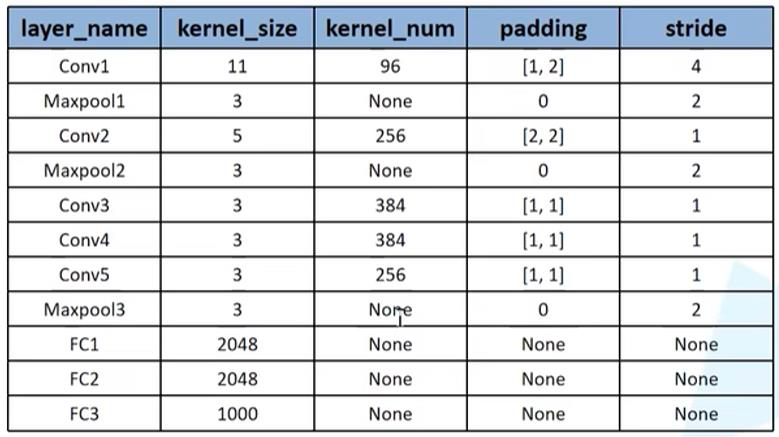

In [2]:
AlexNet_parameters_pictuer = Image.open('F:/download_dataset/AlexNet_parameters.jpg')
AlexNet_parameters_pictuer

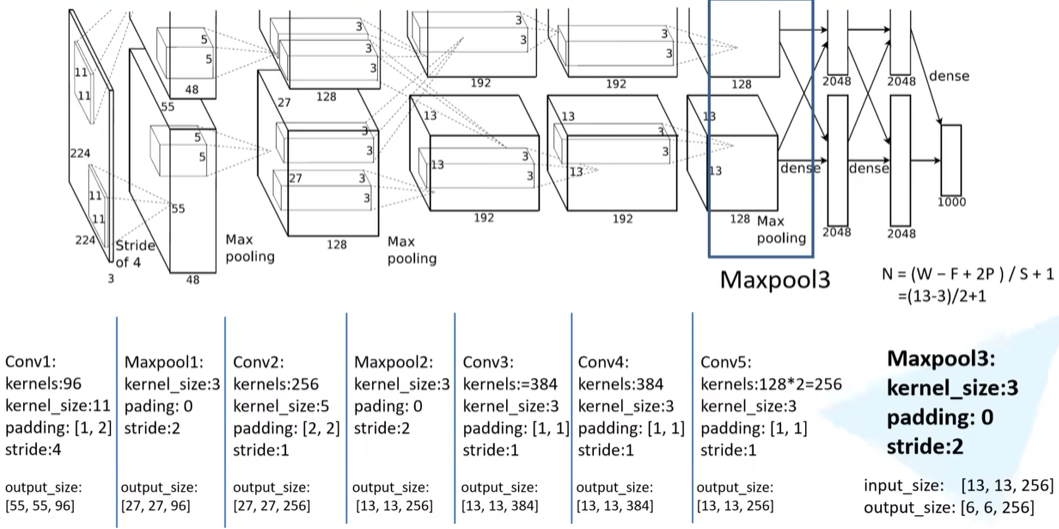

In [3]:
AlexNet_network_pictuer = Image.open('F:/download_dataset/AlexNet_network.jpg')
AlexNet_network_pictuer
# 池化后的维度计算 (55-3)/2+1=27       (input_size-kernel_size)/stride + 1

In [38]:
# 为减少计算量 采用原论文中卷积核一半的数量来构造模型
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, Init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),  # 从而 input(3, 224, 224) output(48, 55, 55)      [224-11+2*2]/4+1 = 55.25
            # pytorch padding 如果传入元组，(1, 2)那么会在上下方各补一行零，左右两侧各补两行零 如果想精确补0，左侧补一列，右侧补两列，可以使用官方的nn.ZeroPaded((1,2,1,2))
            # 为了方便，可以直接写一个2，左右两边和上下两次都补上两行零，这样计算出来的是小数   pytorch为了得到整数  会自动将最下方和最右侧的0舍弃
            nn.ReLU(inplace=True), #inplace参数可以理解为内存中可以载入更大的模型
            nn.MaxPool2d(kernel_size=3, stride=2), # input(48, 55, 55)  output(48, 27, 27)       [55-3]/2+1 = 27
            nn.Conv2d(48, 128, kernel_size=5, padding=2), # input(48, 27, 27)  output(128, 27, 27)      [27-5+2*2]/1+1 = 27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # input(128, 27, 27)  output(128, 13, 13)       [27-3]/2+1 = 13
            nn.Conv2d(128, 192, kernel_size=3, padding=1), # input(128, 13, 13)  output(192, 13, 13)      [13-3+2*1]/1+1 = 13
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1), # input(192, 13, 13)  output(192, 13, 13)      [13-3+2*1]/1+1 = 13
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1), # input(192, 13, 13)  output(128, 13, 13)      [13-3+2*1]/1+1 = 13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # input(128, 13, 13)  output(128, 6, 6)       [13-3]/2+1 = 6
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*6*6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )

        if Init_weights:
            self.Initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
            

    def Initialize_weights(self):
        for m in self.modules():
            # 遍历模型中的每一个结构
            if isinstance(m, nn.Conv2d):
                # 看结构是不是Conv2d
                nn.init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [4]:
import os
import sys
import json
import time

from torchvision import transforms, datasets, utils
from tqdm import tqdm

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224), # 随机裁剪
                                transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [11]:
# 获取训练集 并对训练集进行处理
image_path = 'F:/download_dataset/flower_data/'
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
train_num = len(train_dataset)

In [20]:
# 将类别转化为标签  {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
flower_list
# 将标签字典的键值对反过来
cla_dict = dict((val, key) for key, val in flower_list.items())
cla_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [21]:
# 将上面的字典保存成json文件，方便后续做预测
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [22]:
# 设置迭代的数据
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, shuffle=True,
                                            num_workers=0)
validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                batch_size=4, shuffle=False,
                                                num_workers=0)

print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 3306 images for training, 364 images for validation.


In [40]:
net = AlexNet(num_classes=5, Init_weights=True)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)
epochs = 10
save_path = './AlexNet.pth'
best_acc = 0.0
train_steps = len(train_loader)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20760\3648939090.py:47: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')


In [44]:
# 训练
for epoch in range(epochs):
    # net.train()与net.eval()通过这两个函数，来管理dropout方法，只希望在train过程中使用dropout
    # 调用net.train()就会启用Dropout方法
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    t1 = time.perf_counter()
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        
        # 打印一些统计量
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
    print(time.perf_counter()-t1)

train epoch[1/10] loss:0.846: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s]
47.758599000000686
train epoch[2/10] loss:0.360: 100%|██████████| 104/104 [00:48<00:00,  2.15it/s]
48.48435900000186
train epoch[3/10] loss:0.818: 100%|██████████| 104/104 [00:47<00:00,  2.17it/s]
47.89202819999991
train epoch[4/10] loss:0.704: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s]
47.67807800000082
train epoch[5/10] loss:0.420: 100%|██████████| 104/104 [00:47<00:00,  2.20it/s]
47.19686200000069
train epoch[6/10] loss:0.685: 100%|██████████| 104/104 [00:47<00:00,  2.21it/s]
47.063364900001034
train epoch[7/10] loss:0.708: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s]
47.72679810000045
train epoch[8/10] loss:1.369: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s]
47.77661960000114
train epoch[9/10] loss:0.653: 100%|██████████| 104/104 [00:47<00:00,  2.20it/s]
47.24353090000295
train epoch[10/10] loss:0.850: 100%|██████████| 104/104 [00:49<00:00,  2.11it/s]
49.39455829999861


In [45]:
# 在验证或测试的时候，启用net.eval()，就会关闭Dropout
net.eval()
acc = 0.0
with torch.no_grad():
    val_bar = tqdm(validate_loader, file=sys.stdout)
    for val_data in val_bar:
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))
        predict_y = torch.max(outputs, dim=1)[1]
        # 查看两个是否相等
        acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' % (epoch + 1, running_loss / train_steps, val_accurate))
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)
print('Finished Training')

100%|██████████| 91/91 [00:03<00:00, 23.87it/s]
[epoch 10] train_loss: 0.664  val_accuracy: 0.736
Finished Training


# 预测自己的一张图片

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# load image
img_path = "F:/download_dataset/ppww.png"
img = Image.open(img_path).convert('RGB')
#plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

In [66]:
json_path = './class_indices.json'
with open(json_path, "r") as f:
    class_indict = json.load(f)
# 创建模型
model = AlexNet(num_classes=5).to(device)
# 载入模型权重
weights_path = "./AlexNet.pth"
model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

class: daisy        prob: 0.00535
class: dandelion    prob: 0.00042
class: roses        prob: 0.864
class: sunflowers   prob: 0.000501
class: tulips       prob: 0.13


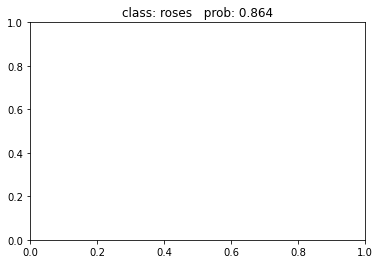

In [67]:
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                predict[i].numpy()))
plt.show()